# Intra-Class Variance

Pruebas para ver si puedo medir el grado de varianza / similitud intra-clase en un dataset de imágenes y usarlo para algo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

from sklearn.decomposition import PCA

La distancia de Minkowski puede servirnos para dirimir el grado de similitud entre dos muestras (tensores). Por ejemplo:

In [2]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])
image_dataset = datasets.ImageFolder('../data/UTKFace/train', data_transforms)
dl = torch.utils.data.DataLoader(image_dataset, batch_size=10, shuffle=True, num_workers=4)

distance: tensor([0.0003])


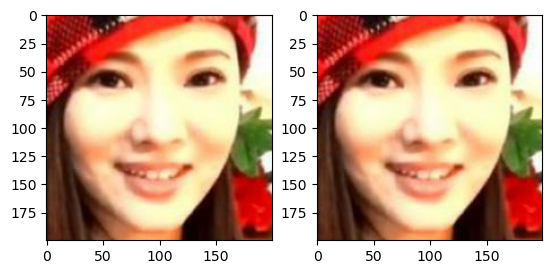

In [6]:
X,_ = next(iter(dl))
im1, im2 = X[4], X[4]
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1.permute(1,2,0))
ax[1].imshow(im2.permute(1,2,0))
dist = nn.PairwiseDistance(p=2.0)(im1.flatten().unsqueeze(0),im2.flatten().unsqueeze(0))
print('distance:', dist)

La diferencia es mínima porque se trata de la misma imagen.

distance: tensor([104.7686])


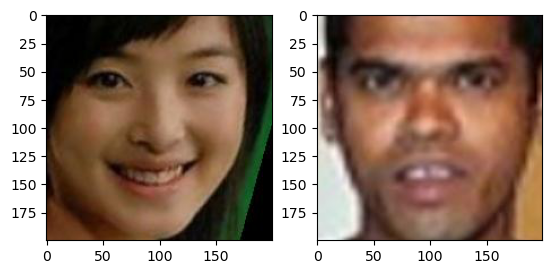

In [14]:
X,_ = next(iter(dl))
im1, im2 = X[0], X[4]
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1.permute(1,2,0))
ax[1].imshow(im2.permute(1,2,0))
dist = nn.PairwiseDistance(p=2.0)(im1.flatten().unsqueeze(0),im2.flatten().unsqueeze(0))
print('distance:', dist)

Aquí la diferencia es más notable porque son imágenes distintas

In [2]:
class Minkowski_Variance:
    def __init__(self, path):
        self.path = path
        data_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.image_dataset = datasets.ImageFolder(path, data_transforms)
        self.class_to_idx = self.image_dataset.class_to_idx
        self.idx_to_class = dict((v,k) for k,v in self.class_to_idx.items())
        print(self.class_to_idx, self.idx_to_class)

        class_0_idxs = torch.nonzero(torch.Tensor(self.image_dataset.targets)==0).flatten()
        class_1_idxs = torch.nonzero(torch.Tensor(self.image_dataset.targets)==1).flatten()

        c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
        b_deg = c0_s / c1_s
        print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

        class_0_subset = Subset(self.image_dataset, class_0_idxs)
        class_1_subset = Subset(self.image_dataset, class_1_idxs)

        class_0_dl = torch.utils.data.DataLoader(class_0_subset, batch_size=10, shuffle=True, num_workers=4)
        class_1_dl = torch.utils.data.DataLoader(class_1_subset, batch_size=10, shuffle=True, num_workers=4)
        
        print('Calculando distancias clase 0...', end='')
        self.class_0_distances = torch.Tensor([])
        for X, _ in class_0_dl:
            distancias = torch.cdist(X.reshape(X.shape[0], -1), X.reshape(X.shape[0], -1))
            sup_t = torch.triu(distancias, diagonal=1)
            sup_t = sup_t[sup_t != 0.]
            self.class_0_distances = torch.cat((self.class_0_distances, sup_t), dim=0)
        print('Done')
        
        print('Calculando distancias clase 1...', end='')
        self.class_1_distances = torch.Tensor([])
        for X, _ in class_1_dl:
            distancias = torch.cdist(X.reshape(X.shape[0], -1), X.reshape(X.shape[0], -1))
            sup_t = torch.triu(distancias, diagonal=1)
            sup_t = sup_t[sup_t != 0.]
            self.class_1_distances = torch.cat((self.class_1_distances, sup_t), dim=0)
        print('Done')

    def plot_histograms(self, width=1, num_bins=50, fig_size=(16, 6)):
        """ Muestra los histogramas de distancias de Minkowski de las clases """
        hist = torch.histogram(self.class_0_distances,
                               bins=torch.linspace(
                                   self.class_0_distances.min(),
                                   self.class_0_distances.max(),
                                   num_bins)
                              )
        _, axs = plt.subplots(1,2, figsize=fig_size)
        axs[0].bar(hist.bin_edges[1:], hist.hist.numpy(), align='edge', width=width, color=['forestgreen'])
        axs[0].set_title(f'Varianza intra-clase, Clase {self.idx_to_class[0]}')
        axs[0].set_xlabel('Distancia de Minkowski')
        axs[0].set_ylabel('Frecuencia')

        hist = torch.histogram(self.class_1_distances,
                               bins=torch.linspace(
                                   self.class_1_distances.min(),
                                   self.class_1_distances.max(),
                                   num_bins)
                              )
        axs[1].set_title(f'Varianza intra-clase, Clase {self.idx_to_class[1]}')
        axs[1].bar(hist.bin_edges[1:], hist.hist.numpy(), align='edge', width=width, color=['blue'])
        axs[1].set_xlabel('Distancia de Minkowski')
        axs[1].set_ylabel('Frecuencia')
        plt.show()
        
    def log_statistics(self):
        """ devuelve medidas estadisticas basicas de un tensor 1-D """
        print(f'Estadisticas dataset: {self.path}')
        print('---------------------------------------------------------')
        for c, D in enumerate([self.class_0_distances, self.class_1_distances]):
            mean = torch.mean(D)
            median = torch.median(D)
            std = torch.std(D)
            var = torch.var(D)
            print(f'== Clase {self.idx_to_class[c]}')
            print(f'\tMedia:\t\t\t\t{mean}')
            print(f'\tMediana:\t\t\t{median}')    
            print(f'\tDesviacion estándar:\t\t{std}')    
            print(f'\tVarianza:\t\t\t{var}')
            
    def plot_PCA(self, s=4):
        print('Computando imagenes...', end='')
        imagenes = np.array([np.array(imagen) for imagen, _ in self.image_dataset])
        print('Done')
        print('Computando etiquetas...', end='')
        etiquetas = np.array([etiqueta for _, etiqueta in self.image_dataset])
        print('Done')
        
        # Aplicamos PCA
        pca = PCA(n_components=2)
        print('Aplicando PCA...', end='')
        pca_resultados = pca.fit_transform(imagenes.reshape(-1, self.image_dataset.__getitem__(0)[0].shape[0]*\
                                                                self.image_dataset.__getitem__(0)[0].shape[1]*\
                                                                self.image_dataset.__getitem__(0)[0].shape[2]))
        print('Done')
        # Creamos un array de colores para cada clase
        colores = ['green' if etiqueta == 0 else 'red' for etiqueta in etiquetas]

        # Creamos la gráfica de PCA
        plt.scatter(pca_resultados[:, 0], pca_resultados[:, 1], c=colores, alpha=0.5, s=s)
        green_patch = mpatches.Patch(color='green', label=self.idx_to_class[0])
        red_patch = mpatches.Patch(color='red', label=self.idx_to_class[1])
        plt.legend(handles=[green_patch, red_patch], loc='upper left')
        plt.title(f'PCA dataset {self.path}')
        plt.show()

## <span style="color:blue">PlantVillage</span>

In [11]:
mv_pv = Minkowski_Variance(path='../data/PlantVillage/train')

{'tomato_healthy': 0, 'tomato_infected': 1} {0: 'tomato_healthy', 1: 'tomato_infected'}
Class 0: 1264 / Class 1: 308 / BDeg:  4.103896103896104
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [12]:
mv_pv.log_statistics()

Estadisticas dataset: ../data/PlantVillage/train
---------------------------------------------------------
== Clase tomato_healthy
	Media:				429.13720703125
	Mediana:			445.30084228515625
	Desviacion estándar:		101.23397827148438
	Varianza:			10248.318359375
== Clase tomato_infected
	Media:				393.49981689453125
	Mediana:			389.5083312988281
	Desviacion estándar:		50.814273834228516
	Varianza:			2582.09033203125


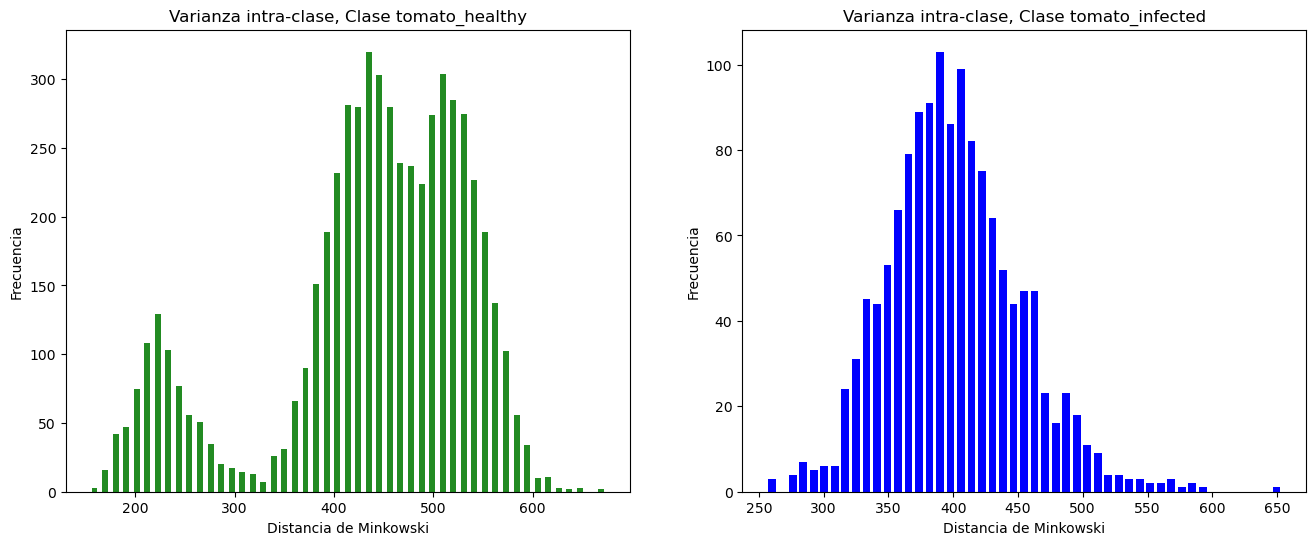

In [13]:
mv_pv.plot_histograms(width=6, num_bins=50, fig_size=(16, 6))

Computando imagenes...Done
Computando etiquetas...Done
Aplicando PCA...Done


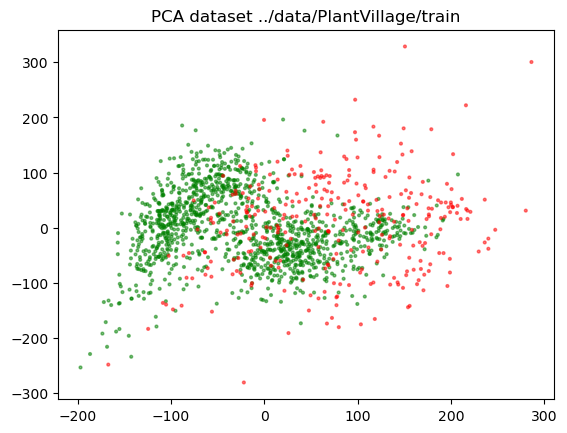

In [25]:
mv_pv.plot_PCA(s=4)

## <span style="color:blue">UTKFace</span>

In [3]:
mv_utk = Minkowski_Variance(path='../data/UTKFace/train')

{'female': 0, 'male': 1} {0: 'female', 1: 'male'}
Class 0: 11317 / Class 1: 12391 / BDeg:  0.913324186909854
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [4]:
mv_utk.log_statistics()

Estadisticas dataset: ../data/UTKFace/train
---------------------------------------------------------
== Clase female
	Media:				468.1497497558594
	Mediana:			457.9006042480469
	Desviacion estándar:		107.5600357055664
	Varianza:			11569.1611328125
== Clase male
	Media:				466.9639587402344
	Mediana:			456.2496032714844
	Desviacion estándar:		106.89059448242188
	Varianza:			11425.599609375


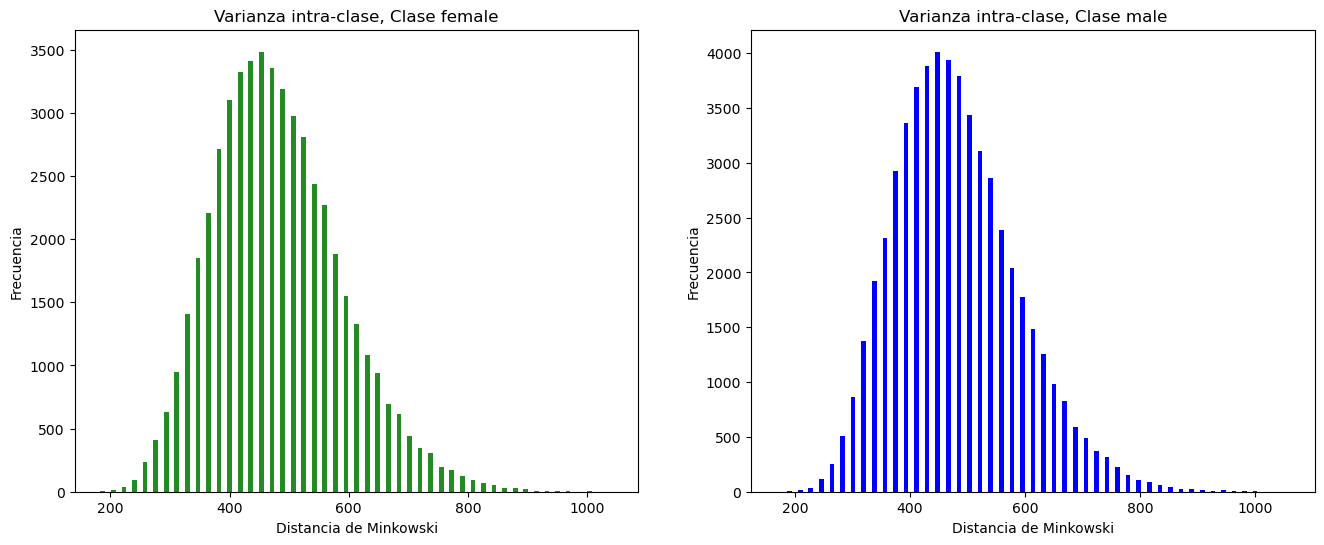

In [5]:
mv_utk.plot_histograms(width=8)

In [ ]:
mv_utk.plot_PCA(s=4)

Computando imagenes...

## <span style="color:blue">Fair Face</span>

In [ ]:
mv_ff = Minkowski_Variance(path='../data/FairFace/train')

In [ ]:
mv_ff.log_statistics()

In [ ]:
mv_ff.plot_histograms(width=10)

In [ ]:
mv_ff.plot_PCA(s=4)

## <span style="color:blue">MNIST (sólo 0 y 1)</span>

In [ ]:
mv_mnist = Minkowski_Variance(path='../data/MNIST')

In [ ]:
mv_mnist.log_statistics()

In [ ]:
mv_mnist.plot_histograms(width=1)

In [ ]:
mv_mnist.plot_PCA(s=4)

# PCA

  0%|          | 0/1963 [00:00<?, ?it/s]

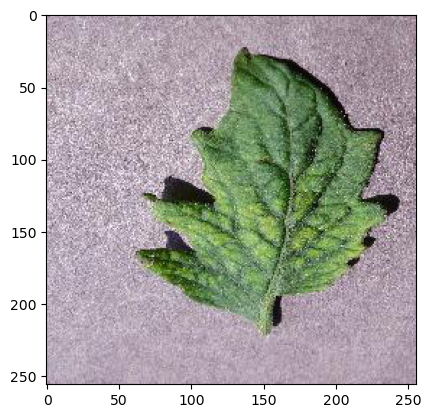

In [13]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

faces = np.zeros((256*256*3))
targets = np.array([])
for path in tqdm(glob.glob('../data/PlantVillage/train/*/*.JPG')):
    img = np.array(Image.open(path))
    plt.imshow(img.transpose(0,1,2))
    faces = np.vstack((faces, img.flatten()))
    if 'tomato_healthy' in path: targets = np.append(targets, 0)
    elif 'tomato_infected' in path: targets = np.append(targets, 1)

In [ ]:
#Import required modules
from sklearn.decomposition import PCA
 
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(faces)

faces.shape, targets.shape, converted_data.shape

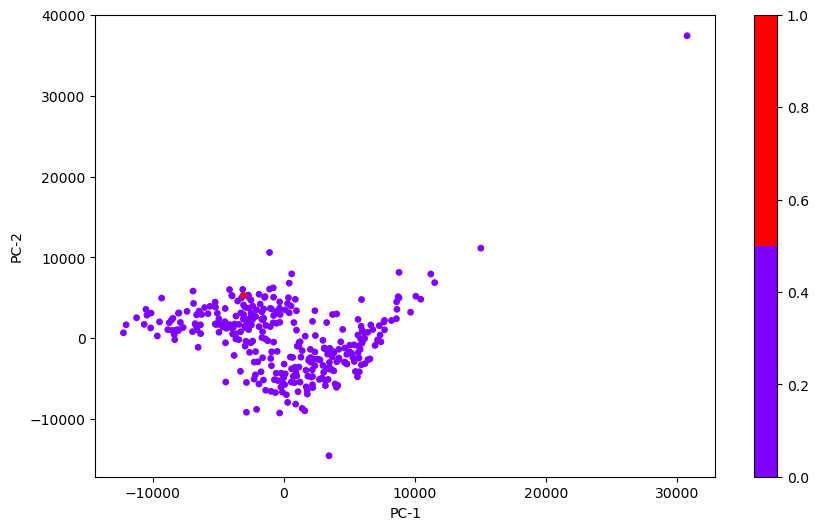

In [11]:
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('rainbow', 2)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = targets)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()